# 05 Explore Valley Wind Events

Now we know the valley orientation for our valleys (see `04_valley_orientation.ipynb` for details) and we downloaded a wide range of different data from stations contained within each basin (as available). 

Questions to address here:

1. How often to wind events > 5 m/s occur in each valley during winter? Which years had more windy events?
2. Do thes wind events follow an up valley-downvalley orientation? Or are they all over the place?
3. Do basins in certain orientations see a greater occurance of big wind events?


Follow up:
1. Which upper air variables from reanalysis correlate with observations at the surface?
2. Do we suppose this is pressure channeling or forced channelling? 

In [4]:
import glob
import os
import pandas as pd
import numpy as np
import geopandas as gpd 
import xarray as xr

from act import discovery, plotting
# plotting
import matplotlib.pyplot as plt
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from scripts.helper_funcs import create_windrose_df, simple_sounding, mean_sounding
import scripts.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

In [5]:
# Import basin geometries and stations
# -------------------------------------
basin_geometries = gpd.read_file('../../01_data/processed_data/east_river_stations/valley_orinetation_basins.geojson')
stations = gpd.read_file('../../01_data/processed_data/east_river_stations/met_station_metadata.geojson')

In [6]:
basin_geometries

,gage_id,name,valley_orientation,valley_orientation_cardinal,geometry
0,09112500,east_river_at_almont,307.5,NW,"POLYGON ((-106.88540 38.66370, -106.88878 38.6..."
1,09112000,cement_creek,22.5,NE,"POLYGON ((-106.82051 38.79981, -106.82827 38.8..."
2,09107000,taylor_river_at_taylor_park,292.5,NW,"POLYGON ((-106.54865 38.85595, -106.55160 38.8..."
3,09063900,missouri_creek_near_gold_park,82.5,E,"POLYGON ((-106.48869 39.35712, -106.49513 39.3..."
4,09065500,gore_creek_at_upper_station,277.5,W,"POLYGON ((-106.21477 39.60422, -106.21660 39.6..."
5,09046600,blue_river_near_dillon,157.5,S,"POLYGON ((-106.05627 39.35841, -106.06838 39.3..."
6,09051050,stright_creek_below_laskey_gulch_nr_dillon,262.5,W,"POLYGON ((-106.05976 39.62409, -106.06750 39.6..."
7,09359500,animas_river_at_tall_timber_resort_above_tacoma,217.5,SW,"POLYGON ((-107.79923 37.54412, -107.80106 37.5..."
8,09358550,cement_creek_at_silverton,202.5,SW,"POLYGON ((-107.67420 37.81947, -107.68210 37.8..."
9,09146200,uncompahgre_river_near_ridgway,142.5,SE,"POLYGON ((-107.73271 37.92982, -107.73839 37.9..."


In [7]:
# lets begin by selecting one basin
name = 'dolores_river_below_rico'
selected_basin_stations = stations[stations['name'] == name]
# create lat and lon columns
selected_basin_stations['lat'] = selected_basin_stations.geometry.y
selected_basin_stations['lon'] = selected_basin_stations.geometry.x
# elevation column
selected_basin_stations['elevation'] = selected_basin_stations.geometry.z

# selected_basin
selected_basin = basin_geometries[basin_geometries['name'] == name]

In [8]:
import json
# get token from .mapbox_token.json file in the home directory
with open('/home/dlhogan/.mapbox_token.json') as f:
    mapbox_token = json.load(f)['token']
f.close()

In [9]:
all_coords = []
for b in selected_basin.geometry.boundary: # for first feature/row
    coords = np.dstack(b.coords.xy).tolist()
    all_coords.append(*coords)   

In [10]:
fig = px.scatter_mapbox(selected_basin_stations,
                        lat="lat",
                        lon="lon",
                        hover_name='name',
                        hover_data=["elevation","id"],
                        # color by elevation
                        color="elevation",
                        color_continuous_scale=px.colors.sequential.Plasma_r,
                        # size_max=24,
                        zoom=10,
                        title=f"Synoptic Stations in {name}",
                        )
# add a trace for the selected basin
fig.add_trace(go.Scattermapbox(
    mode = "lines",
    lat=[c[1] for c in all_coords[0]],
    lon=[c[0] for c in all_coords[0]],
    line = {'color': 'red', 'width': 2},
    name = 'Basin Boundary'
))

fig.update_layout(font_size=16,  title={'xanchor': 'center','yanchor': 'top', 'y':.98, 'x':0.5,}, 
        title_font_size = 24, mapbox_accesstoken=mapbox_token, mapbox_style = 'mapbox://styles/mapbox/outdoors-v12',
        width= 800, height=600, margin={"r":0,"t":40,"l":0,"b":0})

fig

In [11]:
selected_basin_stations['id']

41          EDSC2
42          CARIC
43          E6434
44    739:CO:SNTL
45    586:CO:SNTL
46    465:CO:SNTL
Name: id, dtype: object

In [12]:
mesowest_filepaths = glob.glob('../../01_data/raw_data/station_data/long_term_data/mesowest/*.csv')
snotel_filepaths = glob.glob('../../01_data/raw_data/station_data/long_term_data/sntl_tidy/*.csv')
# filter to only filepaths that contain the selected_basin_stations id
site_paths = []
for path in mesowest_filepaths+snotel_filepaths:
    for site in selected_basin_stations['id'].values:
        site = site.split(':')[0]
        if site in path:
            site_paths.append(path)


In [13]:
def create_tidy_mesowest_df(df, station_id, station_units, filter_to_winter=True):
    # create a tidy dataframe
    tidy_df = df.melt(id_vars=['Date_Time'], var_name='variable', value_name='value')
    # map the units to the variables
    tidy_df['unit'] = tidy_df['variable'].map(station_units[station_id].to_dict())
    # convert types to float 
    tidy_df[~((tidy_df['unit'].isna()) | (tidy_df['unit']=='code'))] = tidy_df[~((tidy_df['unit'].isna()) | (tidy_df['unit']=='code'))].apply(pd.to_numeric, errors='ignore')
    # convert Date_Time to datetime
    tidy_df['Date_Time'] = pd.to_datetime(tidy_df['Date_Time'])
    # if station id is equal to CACB1
    if station_id == 'CACB1':
        # convert rotate the wind_direction_set_1 to be in the correct orientation by sutracting pi/2
        tidy_df.loc[tidy_df['variable'] == 'wind_direction_set_1', 'value'] = tidy_df.loc[tidy_df['variable'] == 'wind_direction_set_1', 'value'] + 90
        # if value is greater than 360 subtract 360
        tidy_df.loc[tidy_df['variable'] == 'wind_direction_set_1', 'value'] = tidy_df.loc[tidy_df['variable'] == 'wind_direction_set_1', 'value'].apply(lambda x: x - 360 if x > 360 else x)
    # set to index
    tidy_df = tidy_df.set_index('Date_Time')
    # convert to datetime
    tidy_df.index = pd.to_datetime(tidy_df.index)
    # filter to only data during cold season months (11,12, 1, 2,3,4)
    if filter_to_winter:
        tidy_df = tidy_df[tidy_df.index.month.isin([11,12,1,2,3,4])]
    return tidy_df

def read_mesowest_data(filepath):
    if 'mesowest' in filepath:
        
        df = pd.read_csv(filepath, comment='#')
        station_id = df['Station_ID'].loc[1]
        station_units = {}
        station_units[station_id] = df.loc[0]
        # drop first row of the dataset and reindex
        df = df.drop(0).reset_index(drop=True)
        # create a tidy dataframe
        tidy_df = create_tidy_mesowest_df(df, station_id, station_units)
        # print the length of the dataset in years
        print(f"{station_id} has {len(tidy_df.index.unique().year.unique())} years of data")
        return tidy_df, station_id
    else:
        print('Not a mesowest file')
        return

def read_sntl_data(filepath, filter_to_winter=True):
    if 'sntl' in filepath:
        df = pd.read_csv(filepath)
        if len(df.query("variable == 'Wind Speed Average (mph)'").value.dropna()) ==0:
            print('No wind data at this site')
            return
        else:
            site_id = filepath.split('/')[-1].split('_')[1]
            # rename Date column to Date_Time
            df = df.rename(columns={'Date':'Date_Time'})
            # set Date_Time to index
            df = df.set_index('Date_Time')
            # convert Date_Time to datetime 
            df.index = pd.to_datetime(df.index)
            # filter to only data during cold season months (11,12, 1, 2,3,4)
            if filter_to_winter:
                df = df[df.index.month.isin([11,12,1,2,3,4])]
            # convert wind speed to m/s from mph
            df.loc[df['variable'] == 'Wind Speed Average (mph)', 'value'] = df.loc[df['variable'] == 'Wind Speed Average (mph)', 'value']*0.44704
            # rename the wind speed variable to change the unit
            df.loc[df['variable'] == 'Wind Speed Average (mph)', 'variable'] = 'Wind Speed Average (m/s)'
        
            # print the length of the dataset in years
            print(f"{site_id}:CO:SNTL has {len(df.index.unique().year.unique())} years of data")
            return df
    else:
        print('Not a sntl file')
        return
    
def get_windy_days(df, wind_speed_var, threshold):
    # get days with wind speed greater than 5 m/s
    mean_wind_speed = df.query(f'variable == "{wind_speed_var}"')['value'].resample('1D').mean()
    # get days with wind speed in the 90th percentile
    # days = mean_wind_speed[mean_wind_speed > mean_wind_speed.quantile(.95)].index
    days = mean_wind_speed[mean_wind_speed > threshold].index
    # filter out days not in months 12,1,2,3,4
    days = days[(days.month >= 12) | (days.month <= 4)]
    print(f"Number of days with wind speed greater than 5 m/s: {len(days)}")
    print(f"Original length: {len(df)}")
    windy_tidy_df = df[pd.to_datetime(df.index.date).isin(days.date)]
    print(f"Filtered length: {len(windy_tidy_df)}")
    return windy_tidy_df

In [14]:
site_paths

['../../01_data/raw_data/station_data/long_term_data/mesowest/CARIC.2024-04-09.csv',
 '../../01_data/raw_data/station_data/long_term_data/mesowest/E6434.2024-04-09.csv',
 '../../01_data/raw_data/station_data/long_term_data/mesowest/EDSC2.2024-04-09.csv',
 '../../01_data/raw_data/station_data/long_term_data/sntl_tidy/El_465_SNTL_tidy.csv',
 '../../01_data/raw_data/station_data/long_term_data/sntl_tidy/Lizard_586_SNTL_tidy.csv',
 '../../01_data/raw_data/station_data/long_term_data/sntl_tidy/Scotch_739_SNTL_tidy.csv']

In [17]:
site = site_paths[3]
if 'mesowest' in site:
    df, site_id = read_mesowest_data(site)
    wind_speed_var = 'wind_speed_set_1'
    wind_dir_var = 'wind_direction_set_1'
else:
    site_id = site.split('/')[-1].split('_')[1]
    df = read_sntl_data(site)
    wind_speed_var = 'Wind Speed Average (m/s)'
    wind_dir_var = 'Wind Direction Average (degree)'

/tmp/ipykernel_6480/673450550.py:45: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



465:CO:SNTL has 39 years of data


In [18]:
windy_tidy_df = get_windy_days(df, wind_speed_var,5)

Number of days with wind speed greater than 5 m/s: 1
Original length: 850410
Filtered length: 216


In [19]:
# set up for wind rose
wind_vars = ['Wind_Speed', 'Wind_Direction']
query_wind_spd = f'variable == "{wind_speed_var}"'
wind_df = windy_tidy_df.query(query_wind_spd).rename(columns={'value': 'Wind_Speed'})
query_wind_dir = f'variable == "{wind_dir_var}"'
wind_df['Wind_Direction'] = windy_tidy_df.query(query_wind_dir)['value']
# filter out wind speeds greater than 40 m/s
wind_df = wind_df[wind_df['Wind_Speed'] < 40]
# creae wind rose
wind_rose_df = create_windrose_df(wind_df, wind_vars[1], wind_vars[0])
# create a wind rose plot using bar_polar
fig = px.bar_polar(wind_rose_df, 
                   r="frequency", 
                   theta="direction", 
                   color="speed", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r,
                   width= 800,
                   height=500,
                   barnorm='percent',
                  )
# update the radial axis to show percentages
fig.update_layout(
    title=f"Wind Rose for {site_id}",
    font_size=12,
    polar_radialaxis=dict(
         ticksuffix='%',
         tickfont_size=14,
         showline=False,
         showticklabels=True,
         showgrid=True,
         angle=45,
         range=[0, 50]
      ),
)

/home/dlhogan/GitHub/Synoptic-Sublimation/02_analysis/data_exploration/scripts/helper_funcs.py:121: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [30]:
df.query(f'variable == "{wind_speed_var}"')['value'].resample('1D').mean() > 2

Date_Time
1986-11-01    False
1986-11-02    False
1986-11-03    False
1986-11-04    False
1986-11-05    False
              ...  
2024-04-05     True
2024-04-06    False
2024-04-07    False
2024-04-08    False
2024-04-09    False
Freq: D, Name: value, Length: 13675, dtype: bool

In [27]:
# get the # of days with wind speed greater than 5 m/s
mean_wind_speed = df.query(f'variable == "{wind_speed_var}"')['value'].resample('1D').mean()
days = mean_wind_speed[mean_wind_speed > 4].index
# filter out days not in months 12,1,2,3,4
days = days[(days.month >= 12) | (days.month < 4)]
mean_wind_speed = mean_wind_speed.loc[days]
mean_wind_speed

Series([], Name: value, dtype: float64)

In [25]:
# add a water year column to the dataframe
mean_wind_speed.name = 'daily_mean_wind_speed'
mean_wind_speed = mean_wind_speed.to_frame()
# convert index to datetime
mean_wind_speed.index = pd.to_datetime(mean_wind_speed.index)
mean_wind_speed['water_year'] = mean_wind_speed.index.year.where(mean_wind_speed.index.month <= 10, mean_wind_speed.index.year + 1)

<Axes: xlabel='water_year'>

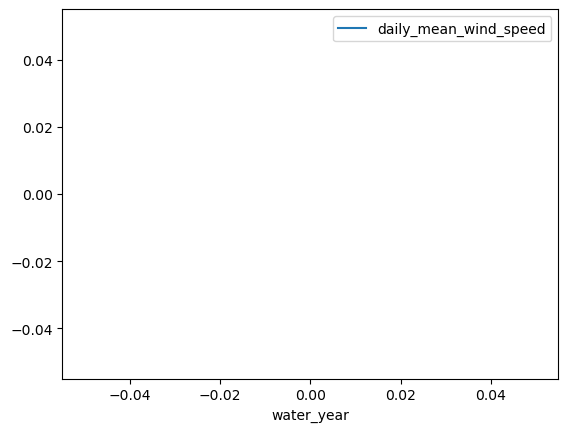

In [26]:
mean_wind_speed.groupby('water_year').count().plot()

ValueError: zero-size array to reduction operation fmin which has no identity

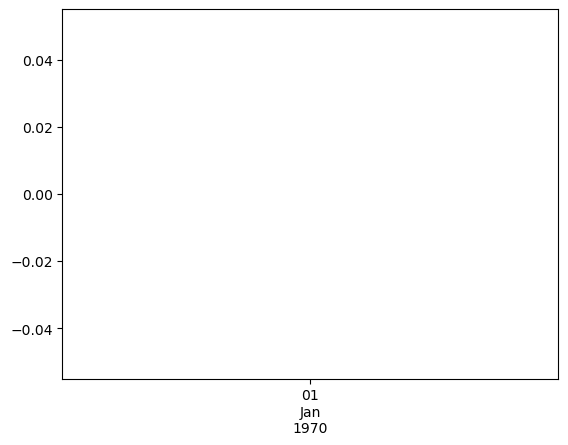

In [23]:
df.query('variable == "wind_speed_set_1"')['value'].resample('1D').mean().plot()